In [26]:
import laser.training.sim.dwi as dwi
from laser.utility.util import *
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import h5py
from dipy.sims import voxel
from dipy.core import gradients

# Diffusion Tensor model

Here we go step-by-step through the dictionary simulation

First we need to define the eigenvalues of our eigenvectors, which model the diffusivity in each direction.  
We assume a diffusivity between 0.0001 and 0.003 μm²/ms for each eigenvalue. We discretize this interval  
here in `N_samples` = 10 steps, and compute a matrix `evals` out of all possible combinations

In [2]:
N_samples = 4
l1 = np.linspace(0.0001, 3E-3, N_samples)
l2 = np.linspace(0.0001, 3E-3, N_samples)
l3 = np.linspace(0.0001, 3E-3, N_samples)

e1, e2, e3 = np.meshgrid(l1, l2, l3, indexing='ij')
evals = np.column_stack([e1.ravel(),e2.ravel(),e3.ravel()]) # contains all possible combinations of eigenvalues and has shape (N_samples^3, 3)

As the eigenvalues need to fulfill the property e1 >= e2 >= e3, we need to filter these eigenvalues

In [3]:
condition = (evals[:,1] <= evals[:,0]) & (evals[:,2] <= evals[:,1])
evals_filt = evals[condition,:]

This will follow a complete eigenvalues combinations of $\sum_{i=1}^{N} \frac{i(i+1)}{2}$
Now we need to take isotropical distributed samples from the unit sphere for our principle eigenvector  
the one with largest eigenvalue e1, in our case we take 20 directions

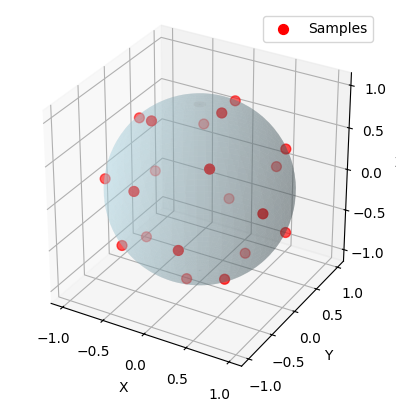

In [5]:
N_samples_first_evec = 20
princ_evec = dwi.sample_from_unit_sphere(N_samples_first_evec)
plot_unit_sphere_samples(princ_evec)

Now that we have all our principle eigenvector directions, let's define the second and third directions according to the principle vector.

The second vector now gets for every principle direction a certain amount of perpendicular possibilities, rotating around the first vector.

The third vector is then just calculated as the perpendicular vector to the first two.

All vectors are normalized.

In [6]:
N_samples_second_evec = N_samples_first_evec//3*2
second_evec = []
third_evec = []

for i in range(princ_evec.shape[0]):
    v = princ_evec[i,:]

    v2, v3 = dwi.get_perp_vecs(v, N_samples_second_evec)
    second_evec.append(v2)
    third_evec.append(v3)

second_evec = np.array(second_evec)
third_evec = np.array(third_evec)

The resulting combinations of all vectors with corresponding eigenvalues can be looked at now (the scaling is adapted):

In [21]:
evals_filt_flipped = np.flipud(evals_filt)

evals_slider = widgets.IntSlider(min=0, max= evals_filt.shape[0]-1, step=1)
princ_vec = widgets.IntSlider(min=0, max= princ_evec.shape[0]-1, step=1)
scd_thr_vec = widgets.IntSlider(min=0, max= second_evec.shape[1]-1, step=1)

@widgets.interact(l1 = princ_vec, l2 = scd_thr_vec, evalue=evals_slider)
def interact_plots(l1, l2, evalue):
    # Select vectors based on slider values
    evalues = evals_filt_flipped[evalue]
    v1 = princ_evec[l1] * evalues[0]*300
    v2 = second_evec[l1][l2] * evalues[1]*300
    v3 = third_evec[l1][l2] * evalues[2]*300
    points = np.vstack((v1, v2, v3))

    # Extract x, y, and z coordinates for plotting
    x_points, y_points, z_points = zip(*points)

    # Create a 3D plot for the unit sphere
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sphere surface
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

    # Plot each vector from the center (0, 0, 0) to the points on the sphere with different colors
    ax.quiver(0, 0, 0, x_points[0], y_points[0], z_points[0], color='red', length=np.linalg.norm(v1), normalize=True, label='v1')
    ax.quiver(0, 0, 0, x_points[1], y_points[1], z_points[1], color='blue', length=np.linalg.norm(v2), normalize=True, label='v2')
    ax.quiver(0, 0, 0, x_points[2], y_points[2], z_points[2], color='green', length=np.linalg.norm(v3), normalize=True, label='v3')

    # Add a legend
    ax.legend()

    # Label axes and set the aspect ratio to be equal
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Remove ticks on the axes
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    ax.set_box_aspect([1, 1, 1])

interactive(children=(IntSlider(value=0, description='l1', max=19), IntSlider(value=0, description='l2', max=1…

Now, using these eigenvectors and eigenvalues, we only need the to the sequence corresponding gradients and b-weightings.

Using these we can then simulate our signals using DiPy and have a look at the resulting signals.

In [34]:
# load gradient directions and b-weightings of sequence
f = h5py.File('../../data/raw/1.0mm_126-dir_R3x3_dvs.h5', 'r')
bvals = f['bvals'][:]
bvecs = f['bvecs'][:]
f.close()
gtab = gradients.gradient_table_from_bvals_bvecs(bvals, bvecs, atol=3e-2)

evals_slider = widgets.IntSlider(min=0, max= evals_filt.shape[0]-1, step=1)
princ_vec = widgets.IntSlider(min=0, max= princ_evec.shape[0]-1, step=1)
scd_thr_vec = widgets.IntSlider(min=0, max= second_evec.shape[1]-1, step=1)

@widgets.interact(l1 = princ_vec, l2 = scd_thr_vec, evalue=evals_slider)
def interact_plots(l1, l2, evalue):
    v1 = princ_evec[l1]
    v2 = second_evec[l1][l2]
    v3 = third_evec[l1][l2]

    evec = np.vstack([v1,v2,v3]).T
    signal = voxel.single_tensor(gtab, S0=1, evals=evals_filt_flipped[evalue], evecs=evec, snr=None, rng=None)

    fig = plt.figure(figsize=(8,4))

    plt.subplot(121)
    plt.plot(signal)
    v1 = princ_evec[l1] * evals_filt_flipped[evalue][0]*300
    v2 = second_evec[l1][l2] * evals_filt_flipped[evalue][1]*300
    v3 = third_evec[l1][l2] * evals_filt_flipped[evalue][2]*300
    points = np.vstack((v1, v2, v3))

    # Extract x, y, and z coordinates for plotting
    x_points, y_points, z_points = zip(*points)

    # Create a 3D plot for the unit sphere
    
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sphere surface
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

    # Plot each vector from the center (0, 0, 0) to the points on the sphere with different colors
    ax.quiver(0, 0, 0, x_points[0], y_points[0], z_points[0], color='red', length=np.linalg.norm(v1), normalize=True, label='v1')
    ax.quiver(0, 0, 0, x_points[1], y_points[1], z_points[1], color='blue', length=np.linalg.norm(v2), normalize=True, label='v2')
    ax.quiver(0, 0, 0, x_points[2], y_points[2], z_points[2], color='green', length=np.linalg.norm(v3), normalize=True, label='v3')

    # Add a legend
    ax.legend()

    # Label axes and set the aspect ratio to be equal
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Remove ticks on the axes
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    ax.set_box_aspect([1, 1, 1])
    plt.subplots(122)


interactive(children=(IntSlider(value=0, description='l1', max=19), IntSlider(value=0, description='l2', max=1…